In [89]:
import numpy as np
import pandas as dp
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import image as mpimg
import seaborn as sns
import os,random
import cv2


from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Conv2D
from keras.optimizers import RMSprop,SGD,Adagrad
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils


In [92]:
TRAIN_DIR='C:\\Users\\zhang\\Desktop\\EE599 coding\\catvsdog\\input\\train\\'
TEST_DIR='C:\\Users\\zhang\\Desktop\\EE599 coding\\catvsdog\\input\\test\\'

ROWS = 224
COLS = 224
CHANNELS = 3
n_train=500
n_test=1000
n_validation=500

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset， seperate training into dog and cat
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog.' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat.' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
train_images_final = train_dogs[:n_train] + train_cats[:n_train] # get n_train*2 training image
validation_images_final=train_dogs[n_train:n_train+n_validation] + train_cats[n_train:n_train+n_validation] # get n_validation*2 validation image
random.shuffle(validation_images_final)
random.shuffle(train_images_final)
test_images_final =  test_images[:n_test]

def read_image(file_path):
    img = mpimg.imread(file_path) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count,  ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images_final)
test = prep_data(test_images_final)
validation=prep_data(validation_images_final)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))
print("Validation shape: {}".format(validation.shape))

Processed 0 of 1000
Processed 500 of 1000
Processed 0 of 1000
Processed 500 of 1000
Processed 0 of 1000
Processed 500 of 1000
Train shape: (1000, 224, 224, 3)
Test shape: (1000, 224, 224, 3)
Validation shape: (1000, 224, 224, 3)


In [93]:
train_labels = []
for i in train_images_final:
    if 'dog.' in i:
        train_labels.append(1)
    else:
        train_labels.append(0)
validation_labels = []
for i in validation_images_final:
    if 'dog.' in i:
        validation_labels.append(1)
    else:
        validation_labels.append(0)

#sns.countplot(train_labels)
#sns.plttitle('Cats and Dogs')

In [94]:
def show_image(dataset,idx):
    img=dataset[idx]
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.show()
    
def show_cats_and_dogs_compare(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(8,4))
    plt.imshow(pair)
    plt.show()

In [96]:
#for i in range (0,10):
#    show_cats_and_dogs_compare(i)

Text(0.5, 1.0, 'Your Average Cat vs. Dog')

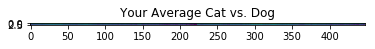

In [17]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if train_labels[i]==1]).mean(axis=0)
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if train_labels[i]==0]).mean(axis=0)

pair = np.concatenate((cat_avg, dog_avg), axis=1)
plt.imshow(pair)
plt.title('Your Average Cat vs. Dog')

In [37]:
a=np.array([dog[0] for i, dog in enumerate(train) if train_labels[i]==1]).mean(axis=-1)
b=np.array([dog[0] for i, dog in enumerate(train) if train_labels[i]==1])
print(a.shape)
print(b.shape)
print(train.shape)

(500, 224)
(500, 224, 3)
(1000, 224, 224, 3)


(1000, 224, 224, 3) (224, 224, 3)


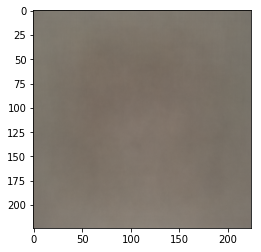

In [67]:
d=train.reshape(1000,224,672)
e=train.reshape(1000,)
f=d.mean(axis=0).reshape(224,224,3)/255
#g=np.trunc(f)
print(train.shape,f.shape)
plt.imshow(f)
#plt.show()
#print(f)

In [129]:
# use VGG-16 to train model
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

def model_vgg16():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(ROWS, COLS,3), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

def model_my():
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(ROWS, COLS,3), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = model_vgg16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 56, 56, 256)       295168    
__________

In [130]:
nb_epoch = 40
batch_size = 20

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, train_labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
              #validation_split=0.25, verbose=0, shuffle=True, callbacks=[history])
    

    #predictions = model.predict(test, verbose=0)
    return history
history = run_catdog()
#model.save('my_model_32_512.h5')

Epoch 00009: early stopping


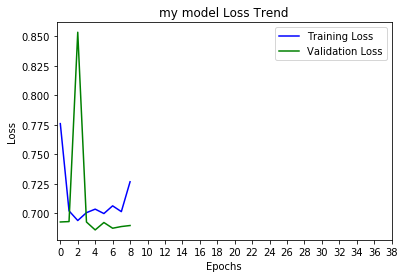

In [131]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('my model Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [132]:
val_predictions = model.predict(validation, verbose=0)
train_predictions=model.predict(train,verbose=0)
test_predictions=model.predict(test,verbose=0)

In [133]:
# test performance on test set(seperate of training part)
def notsure(predictions):
    n_notsure=0
    for i in range (0,len(predictions)):
        if (predictions[i]<0.7 and predictions[i]>0.3):
            n_notsure+=1
    notsure_per=n_notsure/len(predictions)
    return notsure_per

def accuracy(label,predictions):
    n_right=0
    n_dog_precat=0
    n_cat_predog=0
    for i in range (0,len(predictions)):
        if (label[i]==1 and predictions[i]>0.5):
            n_right+=1
        elif (label[i]==1 and predictions[i]<0.5):
            n_dog_precat+=1
        elif (label[i]==0 and predictions[i]<0.5):
            n_right+=1
        else:
            n_cat_predog+=1
    accuracy=n_right/len(predictions)
    dog_precat=n_dog_precat/len(predictions)
    cat_predog=n_cat_predog/len(predictions)
    return accuracy,dog_precat,cat_predog
    
acc,dog_cat,cat_dog=accuracy(validation_labels,val_predictions)
n_not=notsure(val_predictions)

print('the total accuracy is %f, while %f of dog was predict as cat, %f of cat was predict as dog'%(acc,dog_cat,cat_dog))
print('%s of images are not sure enough'%n_not)


the total accuracy is 0.510000, while 0.082000 of dog was predict as cat, 0.408000 of cat was predict as dog
0.998 of images are not sure enough


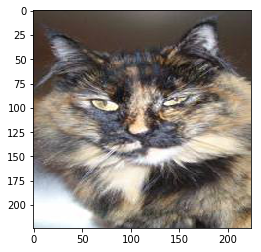

With 0.507394 confidence it's a dog


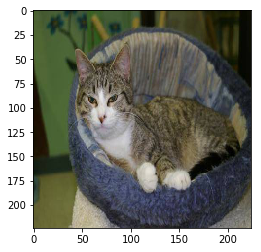

With 0.495726 confidence it's a dog


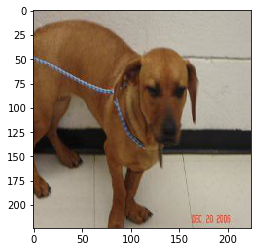

With 0.505796 confidence it's a dog


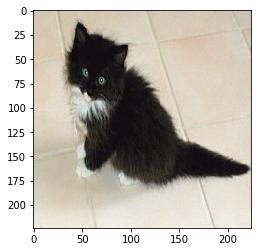

With 0.515260 confidence it's a dog


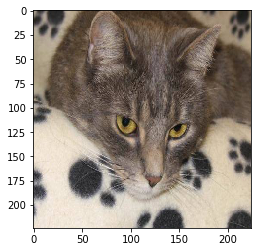

With 0.508608 confidence it's a dog


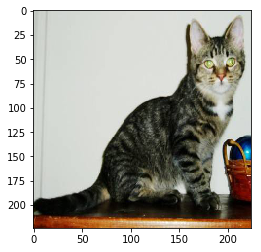

With 0.514120 confidence it's a dog


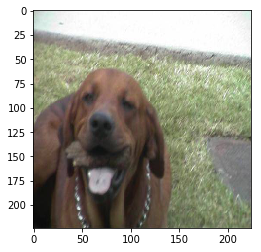

With 0.511799 confidence it's a dog


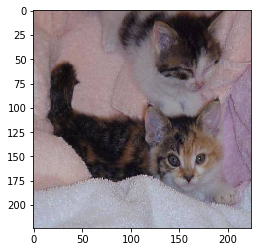

With 0.511523 confidence it's a dog


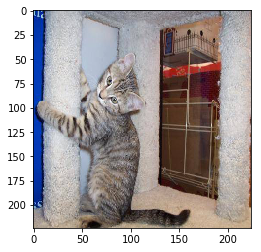

With 0.513644 confidence it's a dog


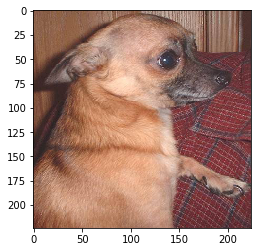

With 0.499327 confidence it's a dog


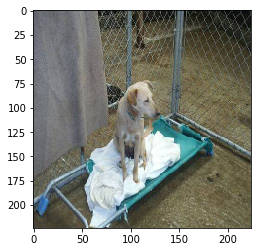

With 0.496615 confidence it's a dog


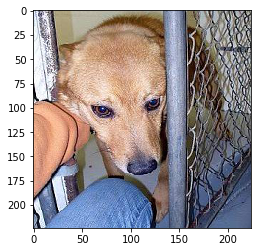

With 0.500720 confidence it's a dog


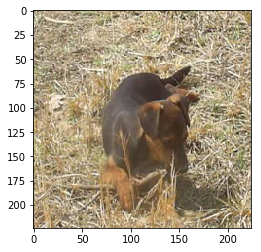

With 0.503059 confidence it's a dog


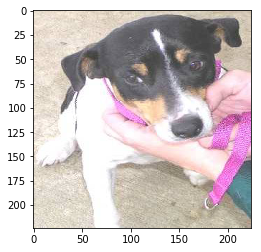

With 0.514758 confidence it's a dog


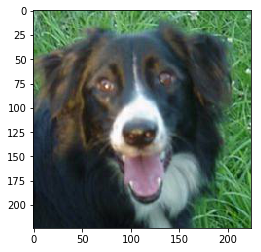

With 0.500590 confidence it's a dog


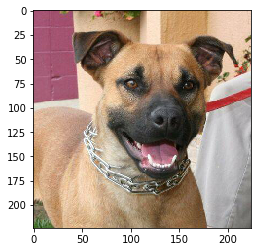

With 0.511894 confidence it's a dog


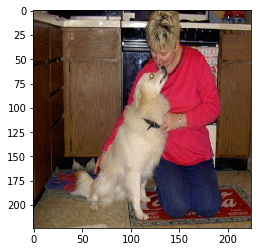

With 0.492308 confidence it's a dog


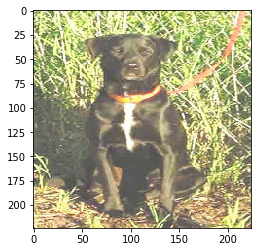

With 0.497378 confidence it's a dog


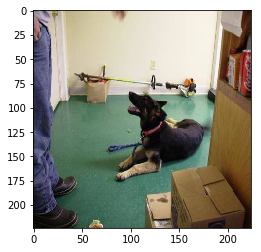

With 0.507548 confidence it's a dog


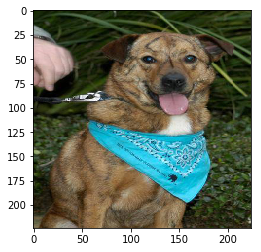

With 0.494198 confidence it's a dog


In [134]:
for idx in range(600,620):
    show_image(validation,idx)
    print("With %f confidence it's a dog" %val_predictions[idx])

In [135]:
model.save('model_vgg16_0.51.h5')